In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

import pickle

sys.path.append("..")
import readseq
import ulmputils

seqDirPath = Config().data_path()/'pseq'

In [3]:
print(ulmputils.vocab.itos)

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'xxfake', 'xxfake']


In [4]:
bs = 64
calcLM = False
#fName = 'swissprotPE3'
fName = 'swissprot'
if calcLM :
    l = TextList.from_csv(seqDirPath,fName+'.csv', cols='sequence',
                      processor=ulmputils.processor)
    print(l[0])
    ulmputils.randomSeedForTraining(3141)
    data_lm = l.split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs)
    data_lm.save(fName+'_lm.pkl')
else :
    data_lm = load_data(seqDirPath, fName+'_lm.pkl', bs=bs)

In [5]:
data_lm.train_ds[0]

(Text xxbos A D T I V A V E L D T Y P N T D I G D P S Y P H I G I D I K S V R S K K T A K W N M Q N G K V G T A H I I Y N S V G K R L S A V V S Y P N G D S A T V S Y D V D L D N V L P E W V R V G L S A T T G L Y K E T N T I L S W S F T S K L K S N S T H E T N A L H F M F N Q F S K D Q K D L I L Q G D A T T G R D G N L E L T R V S S N G S P Q G S S V G R A L F Y A P V H I W E S S A V V A S F D A T F T F L I K S S D S H P A D G I A F F I S N I D S S I P S G S T G R L L G L F P D A N,
 EmptyLabel )

In [6]:
data_lm.show_batch()

idx,text
0,G D S A T V S Y D V D L D N V L P E W V R V G L S A T T G L Y K E T N T I L S W S F T S K L K S N S T H E T N A L H F M F N Q F S K D Q K D
1,E E I N D D N H A E G L I G Y V R E R N Y K G M T L E S V V E L E N G K M V M V S E F F N E D D P D F D H S L D Q K M A I N W V E S W E V V
2,T N F xxbos M K Q S N S K N T P P I A S K K V F I K T Y G C Q M N V Y D S Q R M N D S L S A Q G Y V T T Q T P N D A D L I L V N T C H I R E K A
3,D T E V D L W S V G C I L A E M I E G K P L F P G K D H V H Q F S I I T E L L G S P P P D V I D T I C S E N T L R F V Q S L P H R D P I P F
4,C F E Q Y E K E A Q H L L A L E T P L P L P A Y E R I L K A A H S F N L L D A R K A I S V T E R Q R Y I L R I R T L T K A V A E A Y Y A S R


In [7]:
# tried
# emb_sz=40 - slightly worse
# qrnn=True - unable to run (CUDA_HOME undefined)
emb_sz = 400
n_hid = 1152
n_layers = 3
qrnn = False
awd_lstm_lm_config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [8]:
learn = language_model_learner(data_lm,
            AWD_LSTM, config=dict(awd_lstm_lm_config, emb_sz=emb_sz, n_hid=n_hid,
                                  n_layers=n_layers, qrnn=qrnn),
            pretrained=False, drop_mult=0.2)

In [9]:
# doc(language_model_learner)

In [10]:
learn.data.bptt

70

In [11]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(32, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(32, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=32, bias=True)
    (output_dp): RNNDropout()
  )
)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


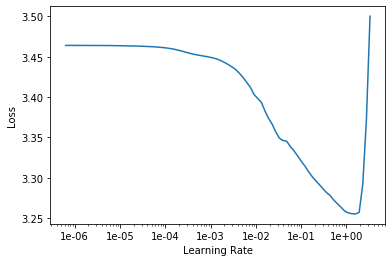

In [17]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(40, 3e-3, moms=(0.8,0.7)) #new

epoch,train_loss,valid_loss,accuracy,time
0,2.401656,2.353648,0.278127,49:48
1,2.160994,2.107268,0.355091,49:39
2,2.135048,2.051626,0.372490,49:24
3,2.108858,2.044425,0.375031,49:12
4,2.101440,2.030173,0.380300,49:10
5,2.031489,2.004342,0.388480,49:08
6,2.022350,1.984236,0.394925,49:13
7,2.024719,1.968187,0.399998,49:08
8,1.991462,1.960227,0.402438,49:13
9,1.997264,1.948606,0.406030,49:09


In [13]:
learn.save('swissp40epoch_0_2dropmult_53acc')

In [9]:
learn.load('swissp40epoch_0_2dropmult_53acc');

In [10]:
learn.save_encoder('swissp40epoch_0_2dropmult_53acc_enc')

In [15]:
learn.fit(4, 5e-5) # after above

epoch,train_loss,valid_loss,accuracy,time
0,1.554619,1.537474,0.531612,49:15
1,1.542405,1.535923,0.532152,49:13
2,1.530765,1.534554,0.532561,49:11
3,1.590924,1.533404,0.532922,49:14


In [10]:
aw = learn.model[0]; aw

AWD_LSTM(
  (encoder): Embedding(32, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(32, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [11]:
weightParam = next(aw.named_parameters()); weightParam

('encoder.weight', Parameter containing:
 tensor([[ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
         [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
         [ 0.1213, -1.2467, -0.2164,  ..., -0.3110,  1.5222, -4.0027],
         ...,
         [ 0.5065, -0.1015, -0.1425,  ..., -0.0086, -0.0285,  0.0102],
         [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
         [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263]],
        device='cuda:0', requires_grad=True))

In [12]:
p = weightParam[1]; p

Parameter containing:
tensor([[ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
        [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
        [ 0.1213, -1.2467, -0.2164,  ..., -0.3110,  1.5222, -4.0027],
        ...,
        [ 0.5065, -0.1015, -0.1425,  ..., -0.0086, -0.0285,  0.0102],
        [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263],
        [ 0.4444, -0.1356,  0.1484,  ..., -0.1760,  0.0262, -0.1263]],
       device='cuda:0', requires_grad=True)

In [13]:
p.shape

torch.Size([32, 400])

In [14]:
aapca = p[9:9+21].pca(3); aapca.shape

torch.Size([21, 3])

In [15]:
ulmputils.aaLetters.index('U')

17

In [16]:
aapca[17],ulmputils.aaLetters[17]

(tensor([17.9907,  0.5116, -1.4092], device='cuda:0', grad_fn=<SelectBackward>),
 'U')

In [78]:
aapca = torch.cat((p[9:9+17],p[9+18:9+21])).pca(2); aapca.shape

torch.Size([20, 2])

In [79]:
aaLetters = ulmputils.aaLetters.replace('U',''); aaLetters, len(aaLetters)

('ACDEFGHIKLMNPQRSTVWY', 20)

In [80]:
fac0,fac1 = aapca.t()

In [81]:
sorted(list(zip(fac0,ulmputils.aaLetters)))

[(tensor(-5.1123, device='cuda:0', grad_fn=<SelectBackward>), 'D'),
 (tensor(-4.4045, device='cuda:0', grad_fn=<SelectBackward>), 'E'),
 (tensor(-4.0296, device='cuda:0', grad_fn=<SelectBackward>), 'N'),
 (tensor(-3.5528, device='cuda:0', grad_fn=<SelectBackward>), 'K'),
 (tensor(-3.3124, device='cuda:0', grad_fn=<SelectBackward>), 'Q'),
 (tensor(-3.0135, device='cuda:0', grad_fn=<SelectBackward>), 'G'),
 (tensor(-2.5176, device='cuda:0', grad_fn=<SelectBackward>), 'R'),
 (tensor(-2.4894, device='cuda:0', grad_fn=<SelectBackward>), 'S'),
 (tensor(-1.6536, device='cuda:0', grad_fn=<SelectBackward>), 'H'),
 (tensor(-1.6461, device='cuda:0', grad_fn=<SelectBackward>), 'P'),
 (tensor(-1.0691, device='cuda:0', grad_fn=<SelectBackward>), 'A'),
 (tensor(-0.7968, device='cuda:0', grad_fn=<SelectBackward>), 'T'),
 (tensor(2.2799, device='cuda:0', grad_fn=<SelectBackward>), 'C'),
 (tensor(3.3543, device='cuda:0', grad_fn=<SelectBackward>), 'U'),
 (tensor(3.6073, device='cuda:0', grad_fn=<SelectB

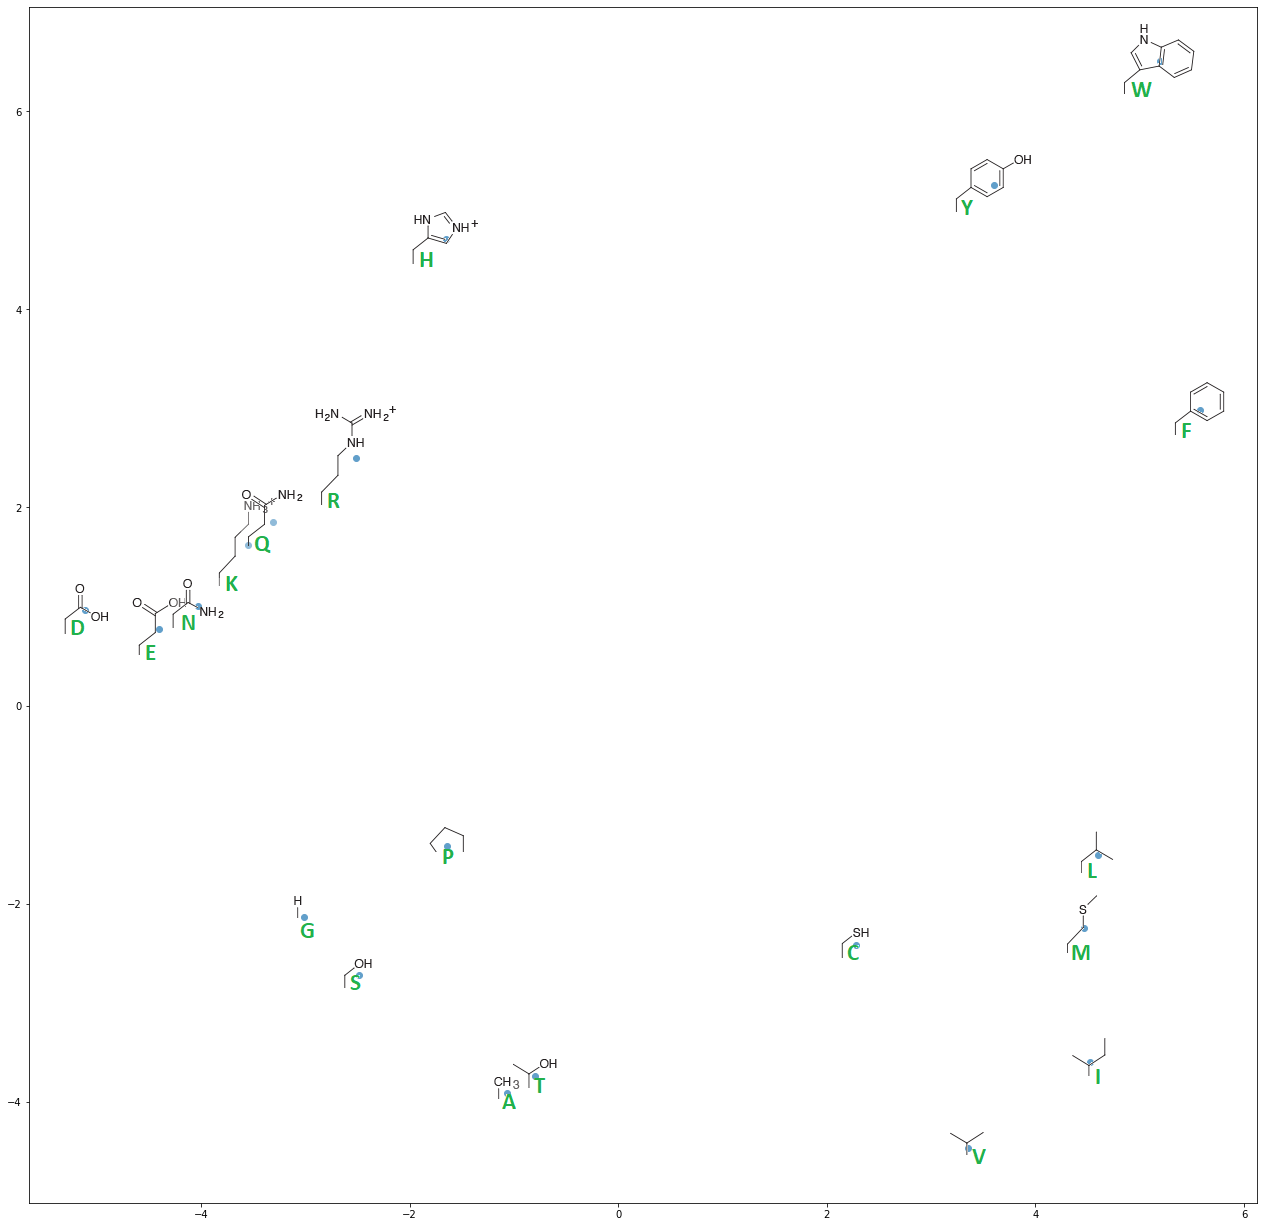

In [87]:
def setAlpha(im) :
    height,width = im.shape[:2]
    for r in range(height) :
        for c in range(width) :
            pix = im[r,c]
            if pix[0]==1.0 and pix[1]==1.0 and pix[2]==1.0 :
                pix[3] = 0.3
            else :
                pix[3] = 1.0
X,Y = fac0, fac1
plt.figure(figsize=(22,22))
ax = plt.subplot(111)
plt.scatter(X, Y)
for i, x, y in zip(aaLetters, X, Y):
    im = plt.imread('aaims/'+i+'.png')
    setAlpha(im)
    imageBox = plt.matplotlib.offsetbox.AnnotationBbox(
        plt.matplotlib.offsetbox.OffsetImage(im),
        (x,y), pad=0.0, frameon=False,
    )
    ax.add_artist(imageBox)
plt.savefig('aapca.png')
plt.show()